In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

Version 1.10.0+cu102
CUDA enabled: False


In [2]:
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import sys
import os
import pickle
import re
import csv
import multiprocessing

import pt_util

In [3]:
DATA_DIR = 'dakshina_dataset_v1.0'
LANG = 'ta'
LANG_DIR = 'lexicons'
DATA_PATH = '{}/{}/{}'.format(DATA_DIR, LANG, LANG_DIR)

In [4]:
def prepare_data(dirpath):
    # Read train and test data
    filenames = os.listdir(dirpath)
    train_data = []
    test_data = []
    max_len = 0 # max length of any word in the dataset
    
    def get_most_annotated_transliterations(tsv_file, data, max_len):
        curr_lang = None
        max_annotations = 0
        curr_translits = {}

        # only consider the most annotated transliteration(s) for each foreign language word
        for lang, en, annotations in tsv_file:
            if not curr_lang or lang != curr_lang:
                for translit, annots in curr_translits.items():
                    if annots == max_annotations:
                        data.append([curr_lang, translit])
                        max_len = max(max_len, len(translit))
                curr_lang = lang
                max_annotations = annotations
                curr_translits = {en: annotations}
                max_len = max(max_len, len(curr_lang))
            else:
                max_annotations = max(max_annotations, annotations)
                curr_translits[en] = annotations
        for translit, annots in curr_translits.items(): # fencepost
            if annots == max_annotations:
                data.append([curr_lang, translit])
                max_len = max(max_len, len(translit))
        return max_len
    
    for filename in filenames:
        with open(os.path.join(dirpath, filename), 'r') as file:
            tsv = csv.reader(file, delimiter='\t')
            if filename.endswith('train.tsv'):
                max_len = get_most_annotated_transliterations(tsv, train_data, max_len)
            else:
                max_len = get_most_annotated_transliterations(tsv, test_data, max_len)
                
    return train_data, test_data, max_len

In [5]:
PAD = '<PAD>'
def create_dictionaries(data):
    #en_voc2ind = {PAD: 0}
    #lang_voc2ind = {PAD: 0}
    #en_ind2voc = {0: PAD}
    #lang_ind2voc = {0: PAD}
    
    en_voc2ind = {}
    lang_voc2ind = {}
    en_ind2voc = {}
    lang_ind2voc = {}
    
    en_ind = 0 #1
    lang_ind = 0 #1
    for lang, en in data:
        for lang_char in lang:
            if lang_char not in lang_voc2ind:
                lang_voc2ind[lang_char] = lang_ind
                lang_ind2voc[lang_ind] = lang_char
                lang_ind += 1
        for en_char in en:
            if en_char not in en_voc2ind:
                en_voc2ind[en_char] = en_ind
                en_ind2voc[en_ind] = en_char
                en_ind += 1
                
    en_voc2ind[PAD] = en_ind
    lang_voc2ind[PAD] = lang_ind
    en_ind2voc[en_ind] = PAD
    lang_ind2voc[lang_ind] = PAD
    
    return lang_voc2ind, lang_ind2voc, en_voc2ind, en_ind2voc

In [6]:
# Preprocessing functions
def tokenize_data(data, voc2ind):
    return [voc2ind[char] for char in data]

def detokenize_and_depad_data(data, ind2voc, pad_val=0):
    res = []
    for ind in data:
        if ind.item() == pad_val:
            break
        res.append(ind2voc[ind.item()])
    return res

def pad_data(data, seq_len, pad_val=0):
    for _ in range(len(data), seq_len):
        data.append(pad_val)
    return data

In [7]:
class TransliterateDataset(torch.utils.data.Dataset):
    
    def __init__(self, data, lang_voc2ind, en_voc2ind, seq_len):
        super(TransliterateDataset, self).__init__()
        
        # Tokenize and pad data
        lang_data = []
        en_data = []
        for lang, en in data:
            lang_tokens = tokenize_data(lang, lang_voc2ind)
            lang_data.append(pad_data(lang_tokens, seq_len, len(lang_voc2ind) - 1))
            en_tokens = tokenize_data(en, en_voc2ind)
            en_data.append(pad_data(en_tokens, seq_len, len(en_voc2ind) - 1))
            
        self.language_data = lang_data
        self.english_data = en_data
        self.sequence_length = seq_len

    def __len__(self):
        return len(self.english_data)
        
    def __getitem__(self, idx):
        # Return the data and label at idx
        return torch.LongTensor(self.language_data[idx]), torch.LongTensor(self.english_data[idx])
    
    def get_random_sample(self):
        return self.__getitem__(np.random.randint(self.__len__()))

In [8]:
class TransliterateNet(nn.Module):
    
    def __init__(self, lang_vocab_size, en_vocab_size, feature_size):
        super(TransliterateNet, self).__init__()
        self.lang_vocab_size = lang_vocab_size
        self.en_vocab_size = en_vocab_size
        self.feature_size = feature_size

        self.encoder = nn.Embedding(self.lang_vocab_size, self.feature_size)
        self.rnn = nn.RNN(self.feature_size, self.feature_size, 2)
        self.decoder = nn.Linear(self.feature_size, self.en_vocab_size)
        
        #self.decoder.weight = self.encoder.weight
        #self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        x = self.encoder(x)
        x, hidden_state = self.rnn(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.en_vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [9]:
def repackage_hidden(h):
    # Wraps hidden states in new Tensors, to detach them from their history
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches.
        # Otherwise the backward would try to go all the way to the beginning every time
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader, lang_ind2voc, en_ind2voc):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    detokenize_and_depad_data(data[0], lang_ind2voc, len(lang_ind2voc) - 1),
                    detokenize_and_depad_data(label[0], en_ind2voc, len(en_ind2voc) - 1),
                    detokenize_and_depad_data(pred[0], en_ind2voc, len(en_ind2voc) - 1)))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cpu
num workers: 56
Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['q', 'w', 'i', 'm', 'n', 'h', 'n', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['i', 'h', 'u', 'i', 'e', 'n', 't', 'g', 'm', 'm']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	[]


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['w', 'i']



Test set: Average loss: 3.2460, Accuracy: 4927/239760 (2%)



  1%|▏         | 1/76 [00:00<00:13,  5.52it/s]

Train Epoch: 0 [0/38723 (0%)]	Loss: 3.255905


 14%|█▍        | 11/76 [00:02<00:14,  4.34it/s]

Train Epoch: 0 [5120/38723 (13%)]	Loss: 1.086130


 29%|██▉       | 22/76 [00:04<00:09,  5.48it/s]

Train Epoch: 0 [10240/38723 (26%)]	Loss: 1.176849


 42%|████▏     | 32/76 [00:06<00:07,  5.56it/s]

Train Epoch: 0 [15360/38723 (39%)]	Loss: 1.219539


 55%|█████▌    | 42/76 [00:07<00:06,  5.60it/s]

Train Epoch: 0 [20480/38723 (53%)]	Loss: 1.140200


 68%|██████▊   | 52/76 [00:09<00:04,  5.36it/s]

Train Epoch: 0 [25600/38723 (66%)]	Loss: 1.001733


 82%|████████▏ | 62/76 [00:11<00:02,  5.59it/s]

Train Epoch: 0 [30720/38723 (79%)]	Loss: 1.092110


 95%|█████████▍| 72/76 [00:13<00:00,  5.56it/s]

Train Epoch: 0 [35840/38723 (92%)]	Loss: 1.111346


100%|██████████| 76/76 [00:14<00:00,  5.40it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['s', 'p', 'a', 'r']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['a', 'e', 't', 'i', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'r', 'a', 't', 'a', 't', 'a', 'p']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'a', 'a']



Test set: Average loss: 0.9798, Accuracy: 180616/239760 (75%)



  1%|▏         | 1/76 [00:00<00:12,  5.91it/s]

Train Epoch: 1 [0/38723 (0%)]	Loss: 0.941664


 16%|█▌        | 12/76 [00:02<00:12,  5.26it/s]

Train Epoch: 1 [5120/38723 (13%)]	Loss: 0.946916


 29%|██▉       | 22/76 [00:04<00:10,  5.08it/s]

Train Epoch: 1 [10240/38723 (26%)]	Loss: 1.148896


 42%|████▏     | 32/76 [00:06<00:08,  5.22it/s]

Train Epoch: 1 [15360/38723 (39%)]	Loss: 1.148189


 55%|█████▌    | 42/76 [00:08<00:06,  5.59it/s]

Train Epoch: 1 [20480/38723 (53%)]	Loss: 1.133134


 68%|██████▊   | 52/76 [00:09<00:04,  5.67it/s]

Train Epoch: 1 [25600/38723 (66%)]	Loss: 0.991637


 82%|████████▏ | 62/76 [00:11<00:02,  5.59it/s]

Train Epoch: 1 [30720/38723 (79%)]	Loss: 1.081855


 95%|█████████▍| 72/76 [00:13<00:00,  5.36it/s]

Train Epoch: 1 [35840/38723 (92%)]	Loss: 1.103379


100%|██████████| 76/76 [00:14<00:00,  5.40it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['o', 'p', 'a', 'r']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['a', 'e', 'r', 'i', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'r', 'a', 't', 'a', 't', 'a', 'p', 'a']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'a', 'a']



Test set: Average loss: 0.9663, Accuracy: 181249/239760 (76%)



  1%|▏         | 1/76 [00:00<00:14,  5.08it/s]

Train Epoch: 2 [0/38723 (0%)]	Loss: 0.913445


 16%|█▌        | 12/76 [00:02<00:12,  5.04it/s]

Train Epoch: 2 [5120/38723 (13%)]	Loss: 0.883890


 28%|██▊       | 21/76 [00:04<00:10,  5.30it/s]

Train Epoch: 2 [10240/38723 (26%)]	Loss: 1.212912


 42%|████▏     | 32/76 [00:06<00:08,  5.08it/s]

Train Epoch: 2 [15360/38723 (39%)]	Loss: 1.133844


 55%|█████▌    | 42/76 [00:08<00:06,  5.63it/s]

Train Epoch: 2 [20480/38723 (53%)]	Loss: 1.131916


 68%|██████▊   | 52/76 [00:09<00:04,  5.64it/s]

Train Epoch: 2 [25600/38723 (66%)]	Loss: 0.984055


 82%|████████▏ | 62/76 [00:11<00:02,  5.65it/s]

Train Epoch: 2 [30720/38723 (79%)]	Loss: 1.060317


 95%|█████████▍| 72/76 [00:13<00:00,  5.65it/s]

Train Epoch: 2 [35840/38723 (92%)]	Loss: 1.086131


100%|██████████| 76/76 [00:14<00:00,  5.40it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['o', 'p', 'a', 'r']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['a', 'e', 'a', 'a', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'a', 'a']



Test set: Average loss: 0.9543, Accuracy: 179483/239760 (75%)



  3%|▎         | 2/76 [00:00<00:15,  4.89it/s]

Train Epoch: 3 [0/38723 (0%)]	Loss: 0.911926


 16%|█▌        | 12/76 [00:02<00:12,  5.22it/s]

Train Epoch: 3 [5120/38723 (13%)]	Loss: 0.874029


 29%|██▉       | 22/76 [00:04<00:09,  5.61it/s]

Train Epoch: 3 [10240/38723 (26%)]	Loss: 1.132556


 42%|████▏     | 32/76 [00:05<00:07,  5.65it/s]

Train Epoch: 3 [15360/38723 (39%)]	Loss: 1.125437


 55%|█████▌    | 42/76 [00:07<00:05,  5.67it/s]

Train Epoch: 3 [20480/38723 (53%)]	Loss: 1.119319


 68%|██████▊   | 52/76 [00:09<00:04,  5.65it/s]

Train Epoch: 3 [25600/38723 (66%)]	Loss: 0.991914


 82%|████████▏ | 62/76 [00:11<00:02,  5.58it/s]

Train Epoch: 3 [30720/38723 (79%)]	Loss: 1.050694


 95%|█████████▍| 72/76 [00:13<00:00,  5.62it/s]

Train Epoch: 3 [35840/38723 (92%)]	Loss: 1.098116


100%|██████████| 76/76 [00:13<00:00,  5.56it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['o', 'p', 'a', 'r']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['a', 'e', 'a', 'a', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'r', 'a', 't', 'a', 't', 'a', 'a', 'a']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'a', 'a']



Test set: Average loss: 0.9557, Accuracy: 181166/239760 (76%)



  1%|▏         | 1/76 [00:00<00:14,  5.14it/s]

Train Epoch: 4 [0/38723 (0%)]	Loss: 0.908232


 14%|█▍        | 11/76 [00:02<00:12,  5.25it/s]

Train Epoch: 4 [5120/38723 (13%)]	Loss: 0.864788


 28%|██▊       | 21/76 [00:04<00:10,  5.34it/s]

Train Epoch: 4 [10240/38723 (26%)]	Loss: 1.149159


 42%|████▏     | 32/76 [00:06<00:08,  5.17it/s]

Train Epoch: 4 [15360/38723 (39%)]	Loss: 1.124951


 55%|█████▌    | 42/76 [00:08<00:06,  5.43it/s]

Train Epoch: 4 [20480/38723 (53%)]	Loss: 1.105677


 67%|██████▋   | 51/76 [00:09<00:04,  5.47it/s]

Train Epoch: 4 [25600/38723 (66%)]	Loss: 0.987910


 82%|████████▏ | 62/76 [00:12<00:02,  5.42it/s]

Train Epoch: 4 [30720/38723 (79%)]	Loss: 1.055371


 95%|█████████▍| 72/76 [00:13<00:00,  5.67it/s]

Train Epoch: 4 [35840/38723 (92%)]	Loss: 1.083642


100%|██████████| 76/76 [00:14<00:00,  5.27it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['o', 'p', 'a', 'r']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['n', 'e', 'a', 'a', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'r', 'a', 't', 'a', 't', 'a', 'p', 'a']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'a', 'a']



Test set: Average loss: 0.9507, Accuracy: 181969/239760 (76%)



  0%|          | 0/76 [00:00<?, ?it/s]

Train Epoch: 5 [0/38723 (0%)]	Loss: 0.899852

  1%|▏         | 1/76 [00:00<00:14,  5.17it/s]

 14%|█▍        | 11/76 [00:02<00:13,  4.90it/s]

Train Epoch: 5 [5120/38723 (13%)]	Loss: 0.853871


 29%|██▉       | 22/76 [00:04<00:09,  5.45it/s]

Train Epoch: 5 [10240/38723 (26%)]	Loss: 1.113089


 42%|████▏     | 32/76 [00:06<00:07,  5.60it/s]

Train Epoch: 5 [15360/38723 (39%)]	Loss: 1.115149


 55%|█████▌    | 42/76 [00:07<00:06,  5.61it/s]

Train Epoch: 5 [20480/38723 (53%)]	Loss: 1.094461


 68%|██████▊   | 52/76 [00:09<00:04,  5.57it/s]

Train Epoch: 5 [25600/38723 (66%)]	Loss: 0.977751


 82%|████████▏ | 62/76 [00:11<00:02,  5.58it/s]

Train Epoch: 5 [30720/38723 (79%)]	Loss: 1.032270


 95%|█████████▍| 72/76 [00:13<00:00,  5.62it/s]

Train Epoch: 5 [35840/38723 (92%)]	Loss: 1.077925


100%|██████████| 76/76 [00:13<00:00,  5.46it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['f', 'p', 'a', 'r']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['n', 'e', 't', 'a', 'i', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['k', 'a', 'a', 'a', 't', 'a', 't', 'a', 'p', 'a']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'a', 'a']



Test set: Average loss: 0.9476, Accuracy: 182131/239760 (76%)



  1%|▏         | 1/76 [00:00<00:12,  6.09it/s]

Train Epoch: 6 [0/38723 (0%)]	Loss: 0.890140


 16%|█▌        | 12/76 [00:02<00:11,  5.63it/s]

Train Epoch: 6 [5120/38723 (13%)]	Loss: 0.862809


 29%|██▉       | 22/76 [00:03<00:09,  5.61it/s]

Train Epoch: 6 [10240/38723 (26%)]	Loss: 1.115503


 42%|████▏     | 32/76 [00:05<00:07,  5.61it/s]

Train Epoch: 6 [15360/38723 (39%)]	Loss: 1.125893


 55%|█████▌    | 42/76 [00:07<00:06,  5.58it/s]

Train Epoch: 6 [20480/38723 (53%)]	Loss: 1.107033


 68%|██████▊   | 52/76 [00:09<00:04,  5.55it/s]

Train Epoch: 6 [25600/38723 (66%)]	Loss: 0.977372


 82%|████████▏ | 62/76 [00:11<00:02,  5.50it/s]

Train Epoch: 6 [30720/38723 (79%)]	Loss: 1.044638


 95%|█████████▍| 72/76 [00:12<00:00,  5.59it/s]

Train Epoch: 6 [35840/38723 (92%)]	Loss: 1.083371


100%|██████████| 76/76 [00:13<00:00,  5.61it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['o', 'p', 'a', 'r']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['n', 'e', 'a', 'a', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'a', 'a', 't', 'a', 't', 'a', 'p', 'a']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'a', 'a']



Test set: Average loss: 0.9651, Accuracy: 181130/239760 (76%)



  1%|▏         | 1/76 [00:00<00:12,  5.91it/s]

Train Epoch: 7 [0/38723 (0%)]	Loss: 0.920235


 16%|█▌        | 12/76 [00:02<00:11,  5.67it/s]

Train Epoch: 7 [5120/38723 (13%)]	Loss: 0.859873


 29%|██▉       | 22/76 [00:03<00:09,  5.44it/s]

Train Epoch: 7 [10240/38723 (26%)]	Loss: 1.145307


 42%|████▏     | 32/76 [00:05<00:08,  5.43it/s]

Train Epoch: 7 [15360/38723 (39%)]	Loss: 1.137558


 55%|█████▌    | 42/76 [00:07<00:06,  5.63it/s]

Train Epoch: 7 [20480/38723 (53%)]	Loss: 1.108426


 68%|██████▊   | 52/76 [00:09<00:04,  5.44it/s]

Train Epoch: 7 [25600/38723 (66%)]	Loss: 0.991307


 82%|████████▏ | 62/76 [00:11<00:02,  5.42it/s]

Train Epoch: 7 [30720/38723 (79%)]	Loss: 1.030739


 95%|█████████▍| 72/76 [00:12<00:00,  5.58it/s]

Train Epoch: 7 [35840/38723 (92%)]	Loss: 1.088654


100%|██████████| 76/76 [00:13<00:00,  5.58it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['o', 'p', 'a', 'r']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['a', 'e', 'a', 'a', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'a', 'a', 't', 'a', 't', 'a', 'p', 'a']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'a', 'a']



Test set: Average loss: 0.9539, Accuracy: 180198/239760 (75%)



  1%|▏         | 1/76 [00:00<00:12,  6.00it/s]

Train Epoch: 8 [0/38723 (0%)]	Loss: 0.903162


 16%|█▌        | 12/76 [00:02<00:11,  5.56it/s]

Train Epoch: 8 [5120/38723 (13%)]	Loss: 0.859713


 29%|██▉       | 22/76 [00:03<00:09,  5.50it/s]

Train Epoch: 8 [10240/38723 (26%)]	Loss: 1.168654


 42%|████▏     | 32/76 [00:05<00:07,  5.64it/s]

Train Epoch: 8 [15360/38723 (39%)]	Loss: 1.132403


 55%|█████▌    | 42/76 [00:07<00:06,  5.63it/s]

Train Epoch: 8 [20480/38723 (53%)]	Loss: 1.114255


 68%|██████▊   | 52/76 [00:09<00:04,  5.47it/s]

Train Epoch: 8 [25600/38723 (66%)]	Loss: 0.983901


 82%|████████▏ | 62/76 [00:11<00:02,  5.55it/s]

Train Epoch: 8 [30720/38723 (79%)]	Loss: 1.040215


 95%|█████████▍| 72/76 [00:12<00:00,  5.60it/s]

Train Epoch: 8 [35840/38723 (92%)]	Loss: 1.089684


100%|██████████| 76/76 [00:13<00:00,  5.58it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['o', 'p', 'a', 'r']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['a', 'e', 'a', 'a', 'r', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'r', 'a', 't', 'a', 't', 'a', 'p']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'a', 'a']



Test set: Average loss: 0.9541, Accuracy: 180965/239760 (75%)



  1%|▏         | 1/76 [00:00<00:12,  6.02it/s]

Train Epoch: 9 [0/38723 (0%)]	Loss: 0.901789


 16%|█▌        | 12/76 [00:02<00:11,  5.58it/s]

Train Epoch: 9 [5120/38723 (13%)]	Loss: 0.866595


 29%|██▉       | 22/76 [00:04<00:10,  5.17it/s]

Train Epoch: 9 [10240/38723 (26%)]	Loss: 1.161297


 42%|████▏     | 32/76 [00:05<00:07,  5.61it/s]

Train Epoch: 9 [15360/38723 (39%)]	Loss: 1.138049


 55%|█████▌    | 42/76 [00:07<00:06,  5.64it/s]

Train Epoch: 9 [20480/38723 (53%)]	Loss: 1.128658


 68%|██████▊   | 52/76 [00:09<00:04,  5.41it/s]

Train Epoch: 9 [25600/38723 (66%)]	Loss: 0.974503


 82%|████████▏ | 62/76 [00:11<00:02,  5.60it/s]

Train Epoch: 9 [30720/38723 (79%)]	Loss: 1.032305


 95%|█████████▍| 72/76 [00:13<00:00,  5.46it/s]

Train Epoch: 9 [35840/38723 (92%)]	Loss: 1.088966


100%|██████████| 76/76 [00:13<00:00,  5.47it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['b', 'p', 'a', 'r']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['n', 'e', 'a', 'a', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'a', 'a', 't', 'a', 't', 'a', 'p']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'k', 'a']



Test set: Average loss: 0.9620, Accuracy: 180062/239760 (75%)



  1%|▏         | 1/76 [00:00<00:12,  6.05it/s]

Train Epoch: 10 [0/38723 (0%)]	Loss: 0.902962


 16%|█▌        | 12/76 [00:02<00:11,  5.54it/s]

Train Epoch: 10 [5120/38723 (13%)]	Loss: 0.871130


 29%|██▉       | 22/76 [00:03<00:09,  5.65it/s]

Train Epoch: 10 [10240/38723 (26%)]	Loss: 1.125967


 42%|████▏     | 32/76 [00:05<00:07,  5.54it/s]

Train Epoch: 10 [15360/38723 (39%)]	Loss: 1.144894


 55%|█████▌    | 42/76 [00:07<00:06,  5.55it/s]

Train Epoch: 10 [20480/38723 (53%)]	Loss: 1.106900


 68%|██████▊   | 52/76 [00:09<00:04,  5.55it/s]

Train Epoch: 10 [25600/38723 (66%)]	Loss: 0.985274


 82%|████████▏ | 62/76 [00:11<00:02,  5.60it/s]

Train Epoch: 10 [30720/38723 (79%)]	Loss: 1.035769


 95%|█████████▍| 72/76 [00:12<00:00,  5.52it/s]

Train Epoch: 10 [35840/38723 (92%)]	Loss: 1.080352


100%|██████████| 76/76 [00:13<00:00,  5.59it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['f', 'p', 'a', 'r']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['a', 'e', 'r', 'a', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'a', 'a', 't', 'a', 't', 'a', 'p']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v']



Test set: Average loss: 0.9676, Accuracy: 181089/239760 (76%)



  1%|▏         | 1/76 [00:00<00:12,  5.93it/s]

Train Epoch: 11 [0/38723 (0%)]	Loss: 0.905542


 16%|█▌        | 12/76 [00:02<00:11,  5.59it/s]

Train Epoch: 11 [5120/38723 (13%)]	Loss: 0.852513


 29%|██▉       | 22/76 [00:04<00:10,  5.35it/s]

Train Epoch: 11 [10240/38723 (26%)]	Loss: 1.120756


 41%|████      | 31/76 [00:05<00:08,  5.55it/s]

Train Epoch: 11 [15360/38723 (39%)]	Loss: 1.115793


 55%|█████▌    | 42/76 [00:07<00:06,  5.53it/s]

Train Epoch: 11 [20480/38723 (53%)]	Loss: 1.135054


 68%|██████▊   | 52/76 [00:09<00:04,  5.46it/s]

Train Epoch: 11 [25600/38723 (66%)]	Loss: 0.971120


 82%|████████▏ | 62/76 [00:11<00:02,  5.57it/s]

Train Epoch: 11 [30720/38723 (79%)]	Loss: 1.036741


 95%|█████████▍| 72/76 [00:13<00:00,  5.58it/s]

Train Epoch: 11 [35840/38723 (92%)]	Loss: 1.074954


100%|██████████| 76/76 [00:13<00:00,  5.52it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['p', 'p', 'a', 'r', 'l', 'm', 'l']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['n', 'e', 'a', 'a', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'p']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'a', 'a']



Test set: Average loss: 0.9643, Accuracy: 181065/239760 (76%)



  1%|▏         | 1/76 [00:00<00:12,  6.04it/s]

Train Epoch: 12 [0/38723 (0%)]	Loss: 0.903154


 16%|█▌        | 12/76 [00:02<00:11,  5.41it/s]

Train Epoch: 12 [5120/38723 (13%)]	Loss: 0.864159


 29%|██▉       | 22/76 [00:03<00:09,  5.50it/s]

Train Epoch: 12 [10240/38723 (26%)]	Loss: 1.126383


 42%|████▏     | 32/76 [00:05<00:08,  5.39it/s]

Train Epoch: 12 [15360/38723 (39%)]	Loss: 1.139157


 55%|█████▌    | 42/76 [00:07<00:06,  5.60it/s]

Train Epoch: 12 [20480/38723 (53%)]	Loss: 1.124459


 67%|██████▋   | 51/76 [00:09<00:04,  5.41it/s]

Train Epoch: 12 [25600/38723 (66%)]	Loss: 0.976278


 82%|████████▏ | 62/76 [00:11<00:02,  5.54it/s]

Train Epoch: 12 [30720/38723 (79%)]	Loss: 1.046728


 95%|█████████▍| 72/76 [00:13<00:00,  5.49it/s]

Train Epoch: 12 [35840/38723 (92%)]	Loss: 1.078067


100%|██████████| 76/76 [00:13<00:00,  5.47it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['x', 'p', 'a', 'r']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['n', 'e', 'a', 'a', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'a', 'a', 't', 'a', 't', 'a', 'p', 'a']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'a', 'a']



Test set: Average loss: 0.9506, Accuracy: 182193/239760 (76%)



  1%|▏         | 1/76 [00:00<00:12,  5.96it/s]

Train Epoch: 13 [0/38723 (0%)]	Loss: 0.902787


 16%|█▌        | 12/76 [00:02<00:11,  5.57it/s]

Train Epoch: 13 [5120/38723 (13%)]	Loss: 0.852868


 29%|██▉       | 22/76 [00:03<00:09,  5.42it/s]

Train Epoch: 13 [10240/38723 (26%)]	Loss: 1.130157


 42%|████▏     | 32/76 [00:05<00:08,  5.46it/s]

Train Epoch: 13 [15360/38723 (39%)]	Loss: 1.102259


 55%|█████▌    | 42/76 [00:07<00:06,  5.57it/s]

Train Epoch: 13 [20480/38723 (53%)]	Loss: 1.124191


 68%|██████▊   | 52/76 [00:09<00:04,  5.60it/s]

Train Epoch: 13 [25600/38723 (66%)]	Loss: 0.974024


 82%|████████▏ | 62/76 [00:11<00:02,  5.37it/s]

Train Epoch: 13 [30720/38723 (79%)]	Loss: 1.045818


 95%|█████████▍| 72/76 [00:13<00:00,  5.52it/s]

Train Epoch: 13 [35840/38723 (92%)]	Loss: 1.091471


100%|██████████| 76/76 [00:13<00:00,  5.53it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['x', 'p', 'a', 'r']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['n', 'e', 'a', 'a', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'a', 'a', 't', 'n', 't', 'a', 'p', 'a']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'a', 'a']



Test set: Average loss: 0.9484, Accuracy: 180974/239760 (75%)



  1%|▏         | 1/76 [00:00<00:12,  5.92it/s]

Train Epoch: 14 [0/38723 (0%)]	Loss: 0.899136


 14%|█▍        | 11/76 [00:01<00:11,  5.55it/s]

Train Epoch: 14 [5120/38723 (13%)]	Loss: 0.846950


 29%|██▉       | 22/76 [00:04<00:09,  5.54it/s]

Train Epoch: 14 [10240/38723 (26%)]	Loss: 1.110531


 42%|████▏     | 32/76 [00:05<00:08,  5.45it/s]

Train Epoch: 14 [15360/38723 (39%)]	Loss: 1.134546


 55%|█████▌    | 42/76 [00:07<00:06,  5.41it/s]

Train Epoch: 14 [20480/38723 (53%)]	Loss: 1.120010


 68%|██████▊   | 52/76 [00:09<00:04,  5.55it/s]

Train Epoch: 14 [25600/38723 (66%)]	Loss: 0.969943


 82%|████████▏ | 62/76 [00:11<00:02,  5.40it/s]

Train Epoch: 14 [30720/38723 (79%)]	Loss: 1.039353


 95%|█████████▍| 72/76 [00:13<00:00,  5.54it/s]

Train Epoch: 14 [35840/38723 (92%)]	Loss: 1.078940


100%|██████████| 76/76 [00:13<00:00,  5.50it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['p', 'p', 'a', 'r', 'n', 'm', 'n']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['n', 'e', 'r', 'i', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['k', 'a', 'a', 'a', 't', 'n', 't', 'a', 'a', 'a']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'a', 'a']



Test set: Average loss: 0.9531, Accuracy: 181964/239760 (76%)



  1%|▏         | 1/76 [00:00<00:12,  5.99it/s]

Train Epoch: 15 [0/38723 (0%)]	Loss: 0.900055


 16%|█▌        | 12/76 [00:02<00:11,  5.50it/s]

Train Epoch: 15 [5120/38723 (13%)]	Loss: 0.849390


 29%|██▉       | 22/76 [00:03<00:09,  5.52it/s]

Train Epoch: 15 [10240/38723 (26%)]	Loss: 1.245606


 42%|████▏     | 32/76 [00:05<00:08,  5.45it/s]

Train Epoch: 15 [15360/38723 (39%)]	Loss: 1.136230


 55%|█████▌    | 42/76 [00:07<00:06,  5.62it/s]

Train Epoch: 15 [20480/38723 (53%)]	Loss: 1.174662


 68%|██████▊   | 52/76 [00:09<00:04,  5.67it/s]

Train Epoch: 15 [25600/38723 (66%)]	Loss: 1.011926


 82%|████████▏ | 62/76 [00:11<00:02,  5.64it/s]

Train Epoch: 15 [30720/38723 (79%)]	Loss: 1.041406


 95%|█████████▍| 72/76 [00:12<00:00,  5.59it/s]

Train Epoch: 15 [35840/38723 (92%)]	Loss: 1.094574


100%|██████████| 76/76 [00:13<00:00,  5.60it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['b', 'p', 'a', 'r', 'm', 'm', 'm']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['n', 'e', 'r', 'i', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'a', 'a', 't', 'a', 't', 'a', 'a', 'i']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v']



Test set: Average loss: 0.9575, Accuracy: 181495/239760 (76%)



  1%|▏         | 1/76 [00:00<00:12,  5.92it/s]

Train Epoch: 16 [0/38723 (0%)]	Loss: 0.927277


 16%|█▌        | 12/76 [00:02<00:11,  5.65it/s]

Train Epoch: 16 [5120/38723 (13%)]	Loss: 0.857431


 29%|██▉       | 22/76 [00:03<00:09,  5.58it/s]

Train Epoch: 16 [10240/38723 (26%)]	Loss: 1.134857


 42%|████▏     | 32/76 [00:05<00:07,  5.64it/s]

Train Epoch: 16 [15360/38723 (39%)]	Loss: 1.149916


 55%|█████▌    | 42/76 [00:07<00:06,  5.57it/s]

Train Epoch: 16 [20480/38723 (53%)]	Loss: 1.137869


 68%|██████▊   | 52/76 [00:09<00:04,  5.58it/s]

Train Epoch: 16 [25600/38723 (66%)]	Loss: 0.987960


 82%|████████▏ | 62/76 [00:11<00:02,  5.57it/s]

Train Epoch: 16 [30720/38723 (79%)]	Loss: 1.049285


 95%|█████████▍| 72/76 [00:12<00:00,  5.59it/s]

Train Epoch: 16 [35840/38723 (92%)]	Loss: 1.098089


100%|██████████| 76/76 [00:13<00:00,  5.62it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['f', 'p', 'a', 'r', 'n', 'm', 'n']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['a', 'e', 'a', 'n', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'a', 'a', 't', 'a', 't', 'a', 'a', 'a']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'a', 'a']



Test set: Average loss: 0.9637, Accuracy: 181125/239760 (76%)



  1%|▏         | 1/76 [00:00<00:12,  6.02it/s]

Train Epoch: 17 [0/38723 (0%)]	Loss: 0.927074


 16%|█▌        | 12/76 [00:02<00:12,  5.09it/s]

Train Epoch: 17 [5120/38723 (13%)]	Loss: 0.875842


 29%|██▉       | 22/76 [00:04<00:09,  5.57it/s]

Train Epoch: 17 [10240/38723 (26%)]	Loss: 1.136894


 42%|████▏     | 32/76 [00:05<00:07,  5.57it/s]

Train Epoch: 17 [15360/38723 (39%)]	Loss: 1.128084


 55%|█████▌    | 42/76 [00:07<00:06,  5.58it/s]

Train Epoch: 17 [20480/38723 (53%)]	Loss: 1.128973


 68%|██████▊   | 52/76 [00:09<00:04,  5.45it/s]

Train Epoch: 17 [25600/38723 (66%)]	Loss: 0.986858


 82%|████████▏ | 62/76 [00:11<00:02,  5.61it/s]

Train Epoch: 17 [30720/38723 (79%)]	Loss: 1.050427


 95%|█████████▍| 72/76 [00:13<00:00,  5.54it/s]

Train Epoch: 17 [35840/38723 (92%)]	Loss: 1.086783


100%|██████████| 76/76 [00:13<00:00,  5.55it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['f', 'p', 'a', 'r']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['n', 'e', 't', 'a', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'r', 'a', 't', 'a', 't', 'a', 'a', 'a']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'k', 'n']



Test set: Average loss: 0.9494, Accuracy: 182083/239760 (76%)



  1%|▏         | 1/76 [00:00<00:12,  5.87it/s]

Train Epoch: 18 [0/38723 (0%)]	Loss: 0.912419


 16%|█▌        | 12/76 [00:02<00:11,  5.54it/s]

Train Epoch: 18 [5120/38723 (13%)]	Loss: 0.854861


 29%|██▉       | 22/76 [00:03<00:09,  5.55it/s]

Train Epoch: 18 [10240/38723 (26%)]	Loss: 1.127791


 42%|████▏     | 32/76 [00:05<00:07,  5.57it/s]

Train Epoch: 18 [15360/38723 (39%)]	Loss: 1.112395


 55%|█████▌    | 42/76 [00:07<00:06,  5.60it/s]

Train Epoch: 18 [20480/38723 (53%)]	Loss: 1.126406


 68%|██████▊   | 52/76 [00:09<00:04,  5.59it/s]

Train Epoch: 18 [25600/38723 (66%)]	Loss: 0.976913


 82%|████████▏ | 62/76 [00:11<00:02,  5.62it/s]

Train Epoch: 18 [30720/38723 (79%)]	Loss: 1.037956


 95%|█████████▍| 72/76 [00:12<00:00,  5.38it/s]

Train Epoch: 18 [35840/38723 (92%)]	Loss: 1.100255


100%|██████████| 76/76 [00:13<00:00,  5.61it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['f', 'p', 'a', 'r']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['n', 'e', 'a', 'a', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['k', 'a', 'a', 'a', 't', 'a', 't', 'a', 'a', 'a']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'a', 'n']



Test set: Average loss: 0.9554, Accuracy: 182728/239760 (76%)



  1%|▏         | 1/76 [00:00<00:12,  5.99it/s]

Train Epoch: 19 [0/38723 (0%)]	Loss: 0.913993


 16%|█▌        | 12/76 [00:02<00:11,  5.55it/s]

Train Epoch: 19 [5120/38723 (13%)]	Loss: 0.869964


 29%|██▉       | 22/76 [00:03<00:09,  5.53it/s]

Train Epoch: 19 [10240/38723 (26%)]	Loss: 1.124503


 42%|████▏     | 32/76 [00:05<00:08,  5.43it/s]

Train Epoch: 19 [15360/38723 (39%)]	Loss: 1.109250


 55%|█████▌    | 42/76 [00:07<00:06,  5.63it/s]

Train Epoch: 19 [20480/38723 (53%)]	Loss: 1.134605


 68%|██████▊   | 52/76 [00:09<00:04,  5.48it/s]

Train Epoch: 19 [25600/38723 (66%)]	Loss: 0.976898


 82%|████████▏ | 62/76 [00:11<00:02,  5.43it/s]

Train Epoch: 19 [30720/38723 (79%)]	Loss: 1.038685


 95%|█████████▍| 72/76 [00:13<00:00,  5.43it/s]

Train Epoch: 19 [35840/38723 (92%)]	Loss: 1.088689


100%|██████████| 76/76 [00:13<00:00,  5.49it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['f', 'p', 'a', 'r', 'i', 'm', 'i']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['n', 'e', 'a', 'a', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['a', 'a', 'r', 'a', 'a', 't', 'a', 'a', 'p', 'a']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'k', 'a']



Test set: Average loss: 0.9480, Accuracy: 181513/239760 (76%)



  1%|▏         | 1/76 [00:00<00:12,  6.07it/s]

Train Epoch: 20 [0/38723 (0%)]	Loss: 0.910805


 16%|█▌        | 12/76 [00:02<00:11,  5.51it/s]

Train Epoch: 20 [5120/38723 (13%)]	Loss: 0.851721


 29%|██▉       | 22/76 [00:03<00:09,  5.54it/s]

Train Epoch: 20 [10240/38723 (26%)]	Loss: 1.116093


 42%|████▏     | 32/76 [00:05<00:07,  5.53it/s]

Train Epoch: 20 [15360/38723 (39%)]	Loss: 1.113337


 55%|█████▌    | 42/76 [00:07<00:06,  5.56it/s]

Train Epoch: 20 [20480/38723 (53%)]	Loss: 1.119520


 68%|██████▊   | 52/76 [00:09<00:04,  5.55it/s]

Train Epoch: 20 [25600/38723 (66%)]	Loss: 0.966347


 82%|████████▏ | 62/76 [00:11<00:02,  5.63it/s]

Train Epoch: 20 [30720/38723 (79%)]	Loss: 1.025685


 95%|█████████▍| 72/76 [00:12<00:00,  5.44it/s]

Train Epoch: 20 [35840/38723 (92%)]	Loss: 1.111349


100%|██████████| 76/76 [00:13<00:00,  5.57it/s]


Input	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
GT	['f', 'a', 'r', 'm']
pred	['f', 'p', 'a', 'r', 'm', 'm', 'm']


Input	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
GT	['n', 'e', 't', 'r', 'i']
pred	['n', 'e', 'r', 'a', 'a', 'i']


Input	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
GT	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
pred	['k', 'a', 'a', 'a', 't', 'a', 't', 'a', 'p']


Input	['வ', 'ா', 'க', 'ன']
GT	['v', 'a', 'a', 'g', 'a', 'n', 'a']
pred	['v', 'a', 'k', 'a']



Test set: Average loss: 0.9557, Accuracy: 182666/239760 (76%)



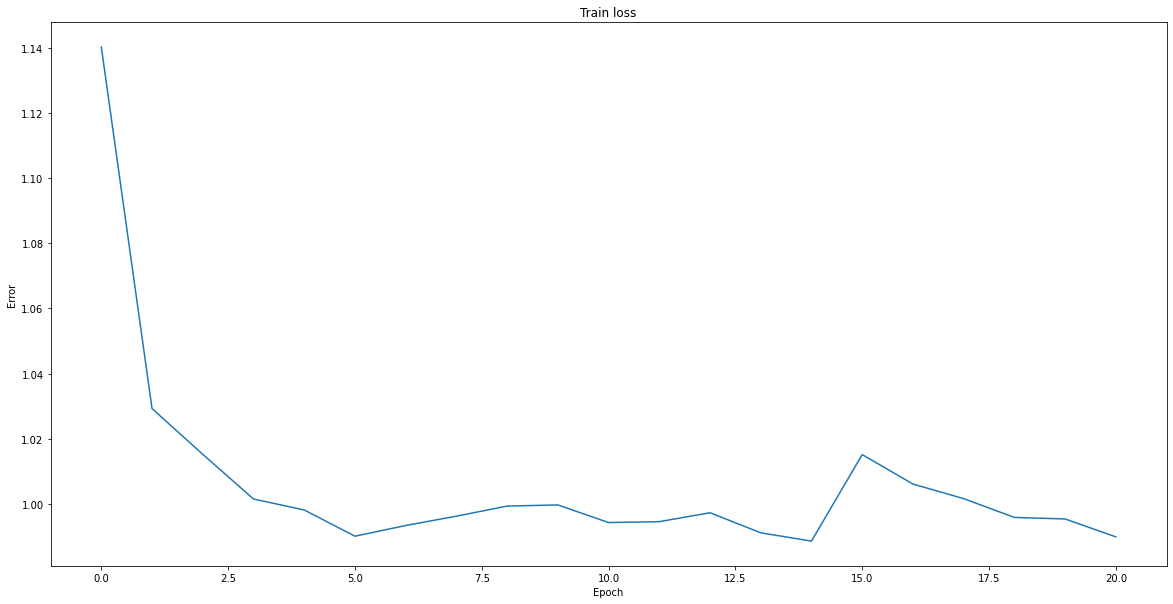

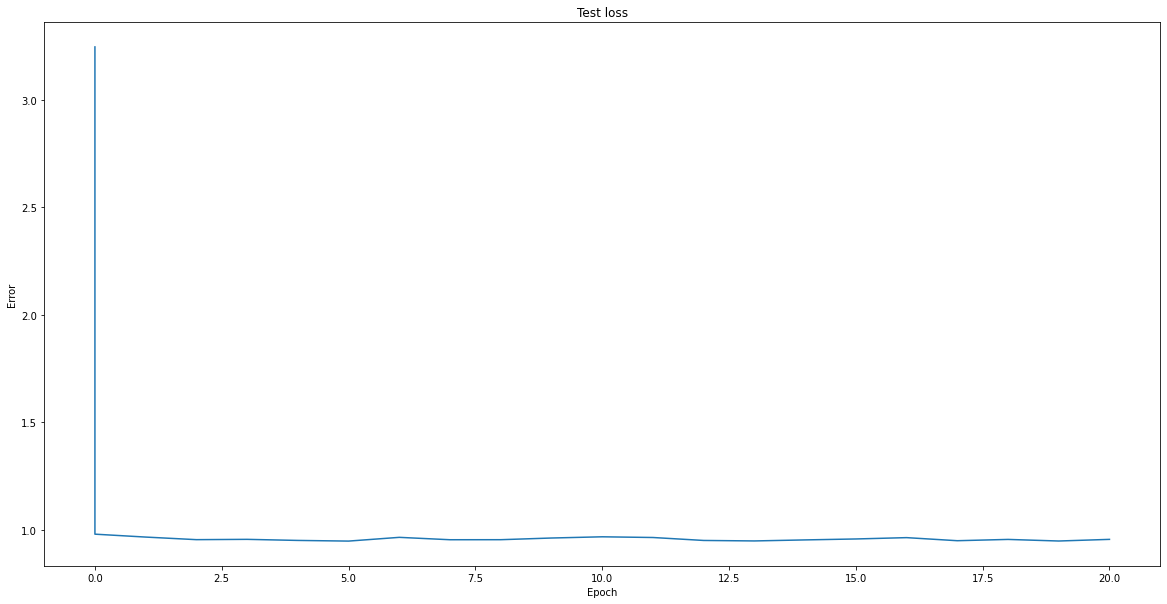

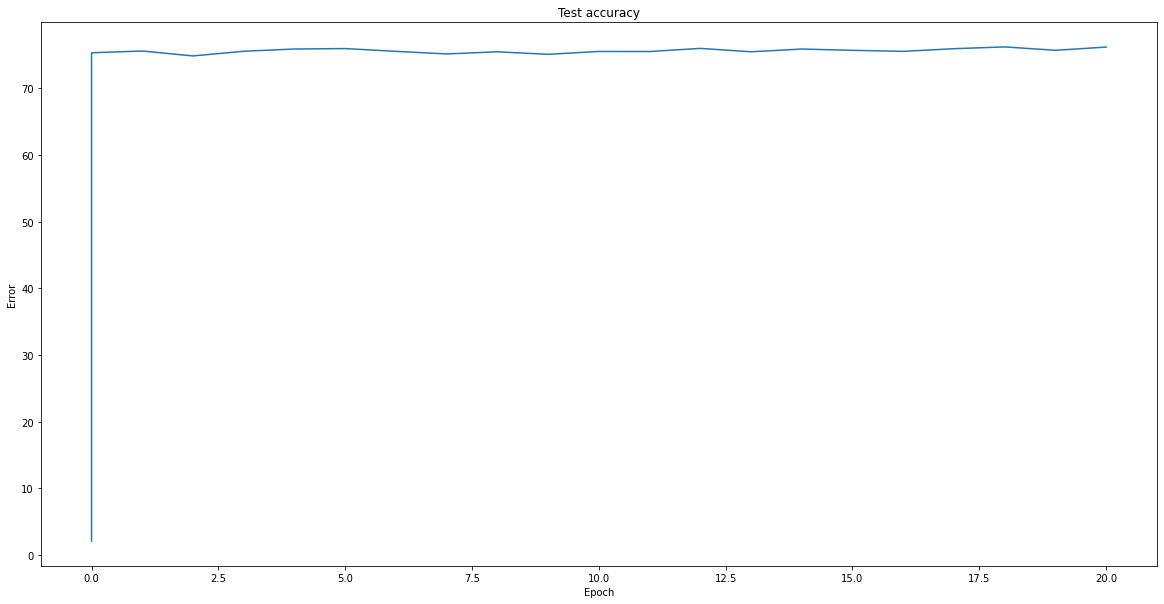

In [10]:
def main():
    BATCH_SIZE = 512
    FEATURE_SIZE = 128
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.005
    MOMENTUM = 0.9
    WEIGHT_DECAY = 0.000005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    OUT_PATH = 'out/'
    LOG_PATH = OUT_PATH + 'logs/log.pkl'
    
    train_data, test_data, seq_len = prepare_data(DATA_PATH)
    lang_voc2ind, lang_ind2voc, en_voc2ind, en_ind2voc = create_dictionaries(train_data + test_data)
    train_dataset = TransliterateDataset(train_data, lang_voc2ind, en_voc2ind, seq_len)
    test_dataset = TransliterateDataset(test_data, lang_voc2ind, en_voc2ind, seq_len)
    
    use_cuda = USE_CUDA and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)
    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)
    
    model = TransliterateNet(len(lang_voc2ind), len(en_voc2ind), FEATURE_SIZE).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    #optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(OUT_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader, lang_ind2voc, en_ind2voc)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))
    
    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader, lang_ind2voc, en_ind2voc)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            #pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            #model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        #print('Saving final model')
        #model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, lang_voc2ind, en_ind2voc, device
    
final_model, lang_voc2ind, en_ind2voc, device = main()

In [11]:
def generate_transliteration(model, word, lang_voc2ind, en_ind2voc, seq_len=30):
    transliteration = []
    hidden = None
    
    lang_tokens = tokenize_data(word, lang_voc2ind)
    lang_data = torch.LongTensor(pad_data(lang_tokens, seq_len))
    
    for c in torch.LongTensor(lang_data):
        x, hidden = model.inference(c, hidden)
        transliteration.append(torch.argmax(x))
    
    return detokenize_and_depad_data(transliteration, en_ind2voc, len(en_ind2voc) - 1)

In [12]:
print(generate_transliteration(final_model, 'ஃபார்ம்', lang_voc2ind, en_ind2voc)) # should ideally say 'farm'

['f', 'p', 'a', 'a']
